In [12]:
import os
import numpy as np
from typing import List, Dict, Any, Tuple
import matplotlib.pyplot as plt
import random
import librosa

# Global configuration for plotting
plt.rcParams["figure.figsize"] = [20, 6]

In [13]:
project_root = os.getcwd()
while "src" not in os.listdir(project_root):
    project_root = os.path.dirname(project_root)

data_root = os.path.join(project_root, "data", "processed", "train")

if not os.path.exists(data_root):
    raise FileNotFoundError(
        "No se encontró la carpeta data, por favor ejecute el script download_data.sh antes de ejecutar este script."
    )

In [14]:
class Sample:
    def __init__(self, data: Dict[str, np.ndarray]):
        self.mixture = data["mixture"]
        self.bass = data["bass"]
        self.drums = data["drums"]
        self.other = data["other"]
        self.vocals = data["vocals"]

    def plot(self):
        # Plot the mixture and the sources on different subplots
        fig, axs = plt.subplots(5, 1)
        axs[0].plot(self.mixture)
        axs[0].set_title("Mixture")
        axs[1].plot(self.bass)
        axs[1].set_title("Bass")
        axs[2].plot(self.drums)
        axs[2].set_title("Drums")
        axs[3].plot(self.other)
        axs[3].set_title("Other")
        axs[4].plot(self.vocals)
        axs[4].set_title("Vocals")
        plt.show()

In [15]:
random_audio = random.choice(os.listdir(data_root))
audio_path = os.path.join(data_root, random_audio)

sample = None
data = np.load(audio_path, allow_pickle=True)
for key in data:
    sample = Sample(data[key].item())
    break

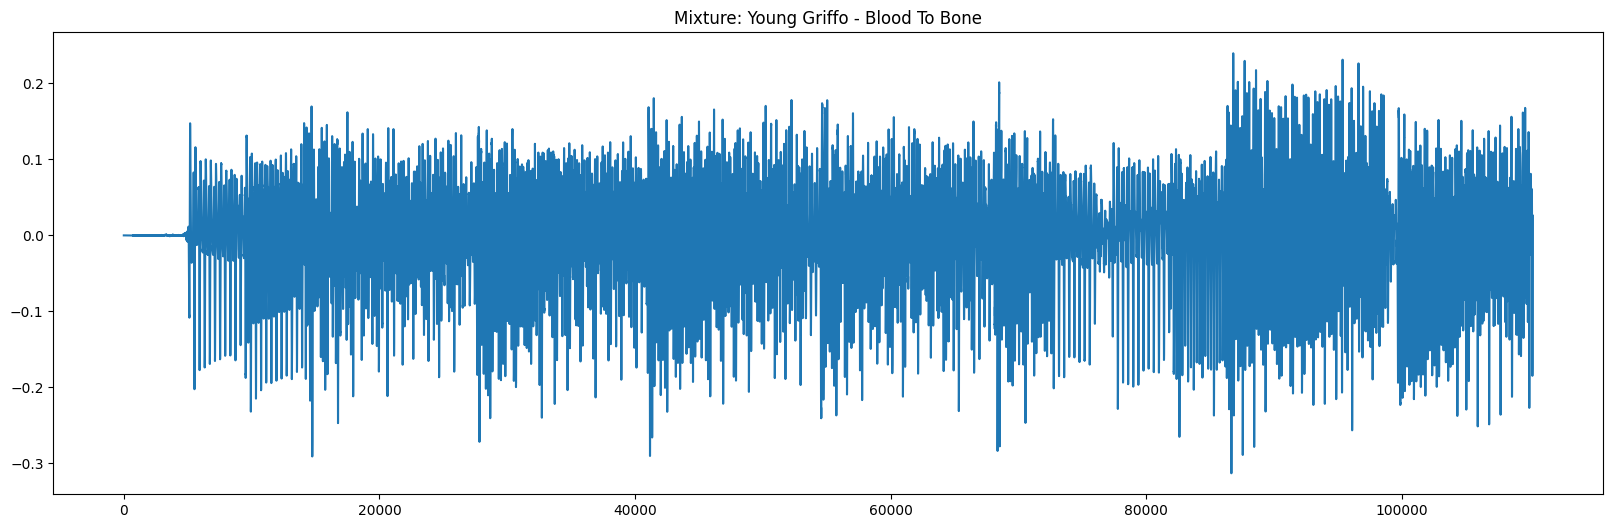

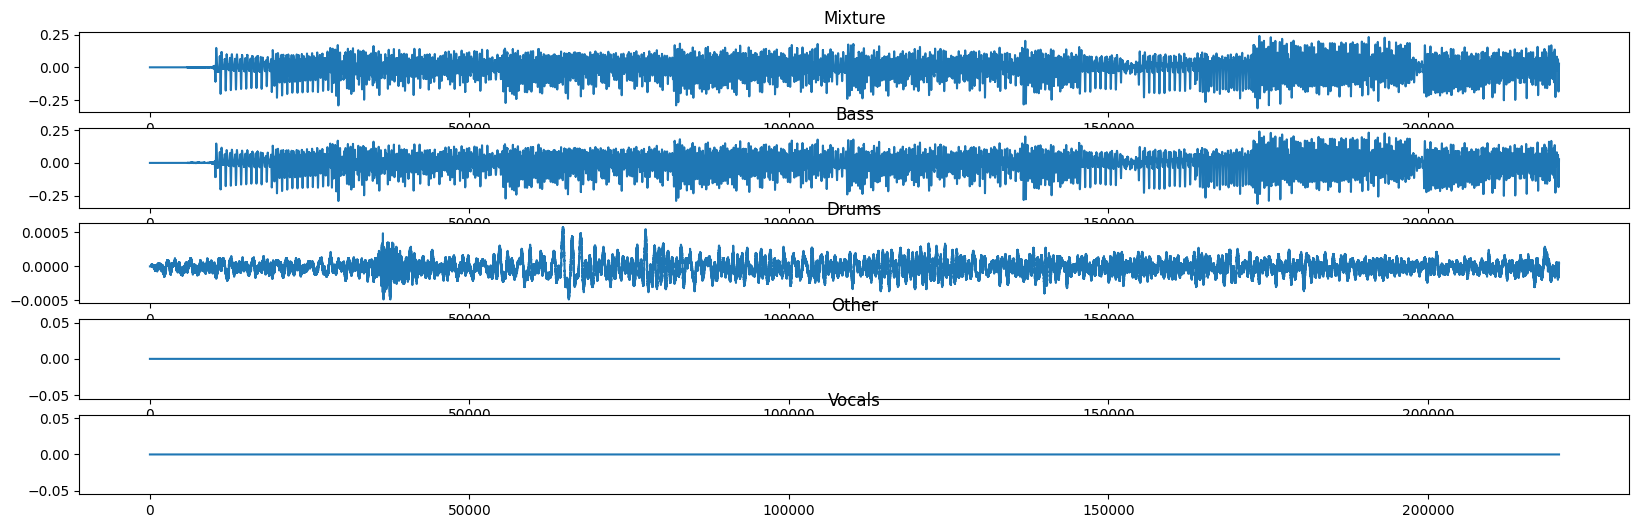

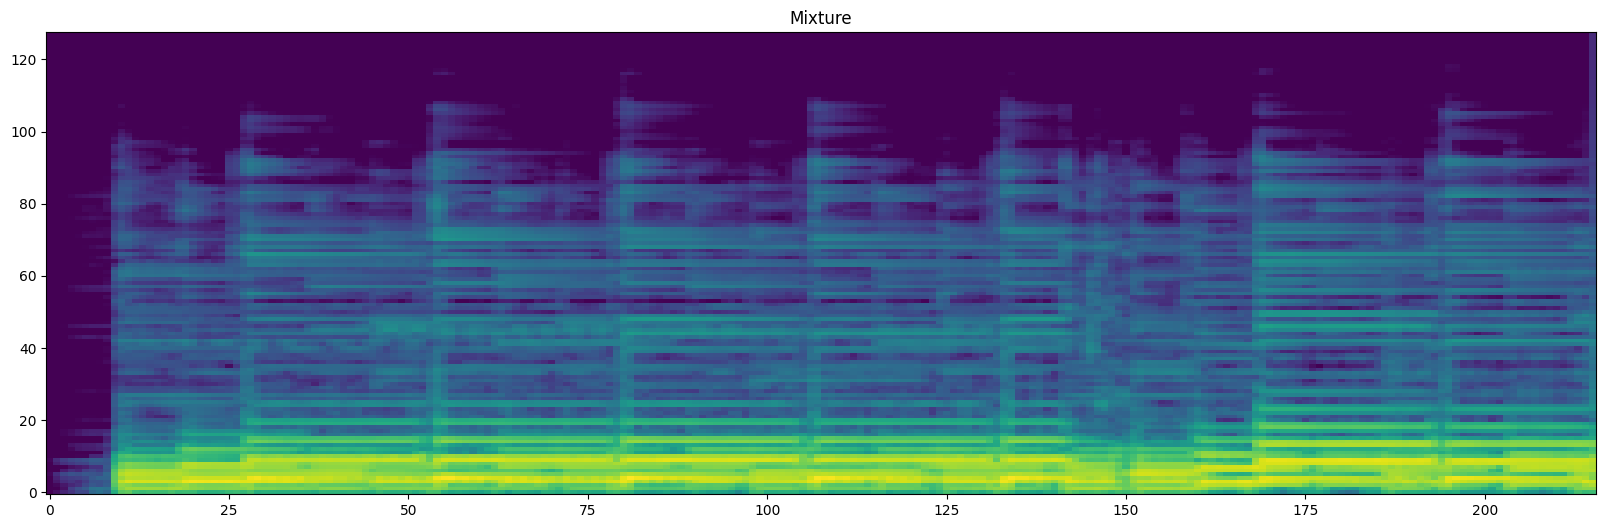

In [16]:
audio_dir = os.path.basename(random_audio).split(".")[0]
mixture_path = os.path.join(
    project_root, "data", "external", "train", audio_dir, "mixture.wav"
)

# Get the first 5 seconds of the mixture audio
y, sr = librosa.load(mixture_path)
y = y[: sr * 5]
plt.title("Mixture: {}".format(audio_dir))
plt.plot(y)
plt.show()
sample.plot()

spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.title("Mixture")
plt.imshow(spectrogram_db, aspect="auto", origin="lower")
plt.show()

In [ ]:
from src.utils.data.dataset import CustomDataset
from src.utils.data.transform import SampleTransformer


def sample_to_stft(
    sample: Sample,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    mixture = librosa.stft(sample.mixture)
    bass = librosa.stft(sample.bass)
    drums = librosa.stft(sample.drums)
    other = librosa.stft(sample.other)
    vocals = librosa.stft(sample.vocals)
    return mixture, bass, drums, other, vocals


for audio in os.listdir(data_root):
    audio_path = os.path.join(data_root, audio)
    data = np.load(audio_path, allow_pickle=True)